In [1]:
import numpy as np 
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from aare import ClusterFinder, calculate_eta2, Interpolator
import boost_histogram as bh
from aare._aare import Cluster2x2d, ClusterVector_Cluster2x2d
import pickle
import os

from test_Interpolation import create_photon_hit_with_gaussian_distribution, create_2x2cluster_from_frame, create_3x3cluster_from_frame, calculate_eta_distribution, photon_hit_in_euclidean_space

In [2]:
### plotting functions

def plot_eta_distribution(eta_distribution):
    plt.imshow(
    eta_distribution[:, :, 0].view().transpose(),   
    origin='lower',                  
    extent=[eta_distribution.axes[0].edges[0], eta_distribution.axes[0].edges[-1], eta_distribution.axes[1].edges[0], eta_distribution.axes[1].edges[-1]],
    aspect='auto')
    plt.colorbar()
    plt.xlabel('eta_x')
    plt.ylabel('eta_y')

def plot_uniform_eta_distribution(uniform_etax, uniform_etay, eta_extent): 
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # (rows, cols)

    im1 = axes[0].imshow(
    uniform_etax[:, :, 0].view().transpose(),   
    origin='lower',                  
    extent=[eta_extent[0], eta_extent[1], eta_extent[0], eta_extent[1]],
    aspect='auto'
    )
    axes[0].set_title("uniform distribution of etax")
    fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    axes[0].set_xlabel("eta_x")
    axes[0].set_ylabel("eta_y")

    im2 = axes[1].imshow(
    uniform_etay[:, :, 0].view().transpose(),   
    origin='lower',                  
    extent=[eta_extent[0], eta_extent[1], eta_extent[0], eta_extent[1]],
    aspect='auto'
    )
    axes[1].set_title("uniform distribution of etay")
    fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    axes[1].set_xlabel("eta_x")
    axes[1].set_ylabel("eta_y")

    plt.tight_layout()
    plt.show()

def plot_photon_hit_distribution(eta_distribution, marg_CDF_etax, cond_CDF_etay): 
    normalized_eta_distribution = eta_distribution.values()[:,:, 0] / eta_distribution.values()[: , :, 0].sum() #normnalize 

    n_samples = 1000
    rng = np.random.default_rng(42)

    flat_indices = rng.choice(
        normalized_eta_distribution.size,
        size=n_samples,
        p=normalized_eta_distribution.ravel())

    x_indices, y_indices = np.unravel_index(flat_indices, normalized_eta_distribution.shape)

    photon_position_x = marg_CDF_etax[x_indices, y_indices]
    photon_position_y = cond_CDF_etay[x_indices, y_indices]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # (rows, cols)

    axes[0].scatter(eta_distribution.axes[0].edges[:-1][x_indices], eta_distribution.axes[1].edges[:-1][y_indices], s=1, alpha=0.5)
    axes[0].set_title("Eta distribution (eta_x, eta_y)")
    #plt.gca().set_aspect('equal')
    axes[0].set_xlabel("eta_x")
    axes[0].set_ylabel("eta_y")
    #axes[0].set_xlim(0,1)
    #axes[0].set_ylim(0,1)

    axes[1].scatter(photon_position_x, photon_position_y, s=1, alpha=0.5)
    axes[1].set_title("uniform Photon positions")
    #plt.gca().set_aspect('equal')
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    #axes[1].set_xlim(0,1)
    #axes[1].set_ylim(0,1)



In [3]:
pixel_width = 1e-4

values = np.arange(0.5*pixel_width, 0.1, pixel_width)

num_pixels = values.size

print(f"num pixels: ({values.size} x {values.size})")

X, Y = np.meshgrid(values, values)

data_points = np.stack([X.ravel(), Y.ravel()], axis=1)

num pixels: (1000 x 1000)


Text(0, 0.5, 'y_0')

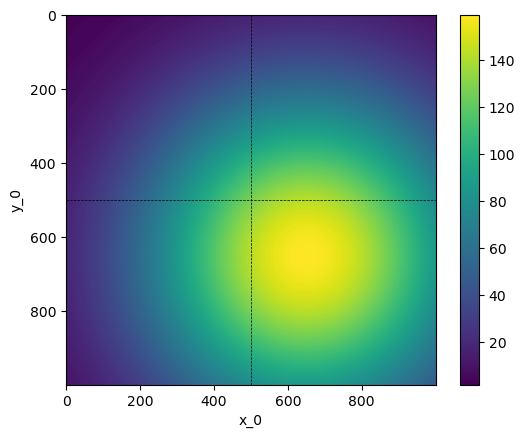

In [4]:
# mean is in bottom right quadrant 
variance = 10*pixel_width

covariance_matrix = np.array([[variance, 0], [0, variance]])

mean = 650*pixel_width

mean = np.array([mean, mean])

base_frame = create_photon_hit_with_gaussian_distribution(mean, variance, data_points)

pixels_per_superpixel = int(num_pixels*0.5)

plt.imshow(base_frame) 

plt.colorbar()

plt.axvline(x=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)

plt.xlabel('x_0')
plt.ylabel('y_0')

In [5]:
### create eta distribution
num_frames = 5000
random_number_generator = np.random.default_rng(42)
eta_distribution = calculate_eta_distribution(num_frames, pixels_per_superpixel, random_number_generator, bh.axis.Regular(100, -0.1, 0.6), bh.axis.Regular(100, -0.1, 0.6))

test_data_path = os.getenv("AARE_TEST_DATA") + "/eta_distributions"
filename = test_data_path + "/eta_distribution_2x2cluster_gaussian.pkl"
with open(filename, "wb") as f:
    pickle.dump(eta_distribution, f)

In [7]:
filename = os.getenv("AARE_TEST_DATA") + "/eta_distributions/eta_distribution_2x2cluster_gaussian.pkl"
with open(filename, "rb") as f:
        eta_distribution = pickle.load(f)

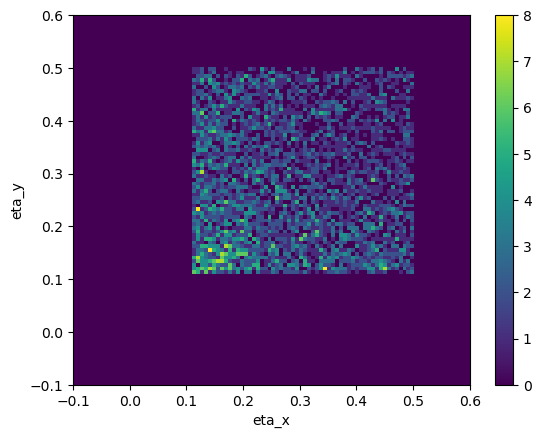

In [8]:
plot_eta_distribution(eta_distribution)

In [9]:
interpolator = Interpolator(eta_distribution, eta_distribution.axes[0].edges, eta_distribution.axes[1].edges, eta_distribution.axes[2].edges[:-1])
#interpolator = Interpolator(eta_distribution.axes[0].edges, eta_distribution.axes[1].edges, eta_distribution.axes[2].edges[:-1])

#interpolator.rosenblatttransform(eta_distribution.values())


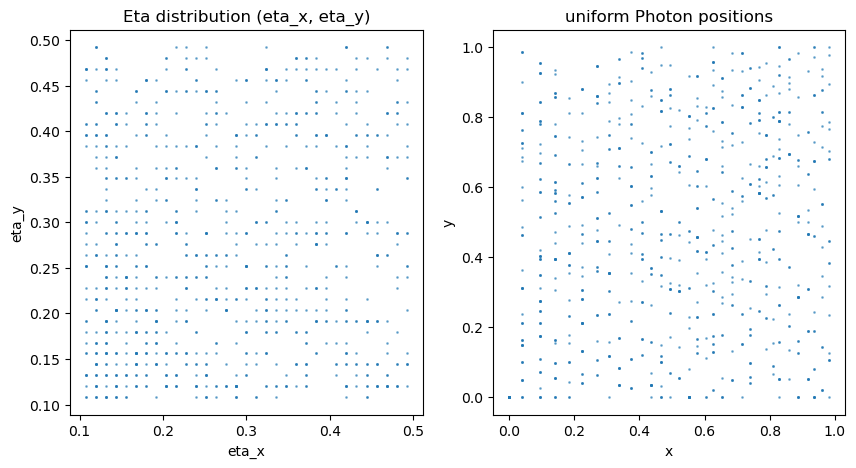

In [18]:
marg_CDF_etax = interpolator.get_ietax()
cond_CDF_etay = interpolator.get_ietay()

plot_photon_hit_distribution(eta_distribution, marg_CDF_etax, cond_CDF_etay)



In [10]:
marg_CDF_etax = interpolator.get_ietax()
cond_CDF_etay = interpolator.get_ietay()

#plot_uniform_eta_distribution(uniform_etax, uniform_etay, [eta_distribution.axes[0].edges[0], eta_distribution.axes[0].edges[-1]])

In [11]:

cluster = create_2x2cluster_from_frame(base_frame, pixels_per_superpixel)

print("cluster.x:", cluster.x)
print("cluster.y:", cluster.y)
clustervec = ClusterVector_Cluster2x2d()
clustervec.push_back(cluster)

eta = calculate_eta2(cluster)
print("eta: ", eta)
bin_size = (eta_distribution.axes[0].edges[-1] - eta_distribution.axes[0].edges[0])/eta_distribution.axes[0].edges.shape[0]

bin_index_x = int((eta[0] - eta_distribution.axes[0].edges[0])/bin_size)
bin_index_y = int((eta[1] - eta_distribution.axes[1].edges[0])/bin_size)

print("distance x:", marg_CDF_etax[bin_index_x, bin_index_y, 0])
print("distance y:", cond_CDF_etay[bin_index_x, bin_index_y, 0])

photon_hit = interpolator.interpolate(clustervec)

print(photon_hit)



cluster.x: 1
cluster.y: 1
eta:  (0.3519491547025806, 0.3519491547025806, 71553511.0)
distance x: 0.7083333333333334
distance y: 0.7564102564102564
[(0.78166653, 0.81284991, 71553511.)]


In [12]:
# scale to cluster pixel width 
#cluster_center = num_pixels*0.75*pixel_width
cluster_center = (pixels_per_superpixel*pixel_width*(cluster.x + 0.5), pixels_per_superpixel*pixel_width*(cluster.y + 0.5))
#scaled_photon_hit = photon_hit_in_euclidean_space(cluster_center, pixels_per_superpixel, photon_hit)

print(photon_hit[0])

scaled_photon_hit = ((photon_hit[0][0])*pixels_per_superpixel*pixel_width, (photon_hit[0][1])*pixels_per_superpixel*pixel_width)

print(f"previous center: ({cluster_center[0]}, {cluster_center[1]})")
print(f"interpolated center: ({photon_hit[0][0]},{photon_hit[0][1]})")
print(f"scaled interpolated center: ({scaled_photon_hit[0]},{scaled_photon_hit[1]})")
print(f"actual center: ({mean},{mean})")

(0.7816665310999981, 0.8128499138725078, 71553511.0)
previous center: (0.07500000000000001, 0.07500000000000001)
interpolated center: (0.7816665310999981,0.8128499138725078)
scaled interpolated center: (0.03908332655499991,0.040642495693625394)
actual center: ([0.065 0.065],[0.065 0.065])


Text(0, 0.5, 'y_0')

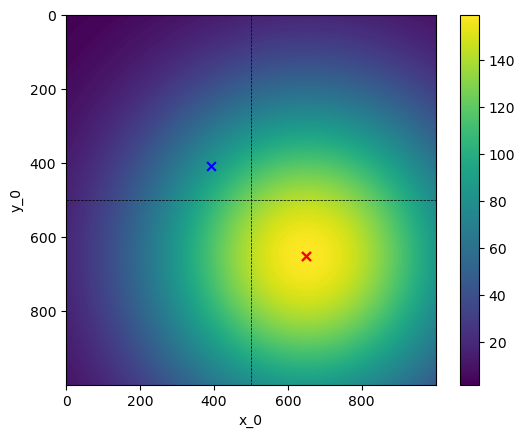

In [13]:
plt.imshow(base_frame) 

plt.colorbar()

plt.axvline(x=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)

plt.scatter(mean/pixel_width, mean/pixel_width, color='red', s=40, marker='x', label='Actual photon hit')
plt.scatter(scaled_photon_hit[0]/pixel_width, scaled_photon_hit[1]/pixel_width, color = 'blue', s=40, marker='x', label='interpolated photon hit')

plt.xlabel('x_0')
plt.ylabel('y_0')

## 3x3 Cluster

In [14]:
from aare._aare import Cluster3x3d, ClusterVector_Cluster3x3d

Text(0, 0.5, 'y_0')

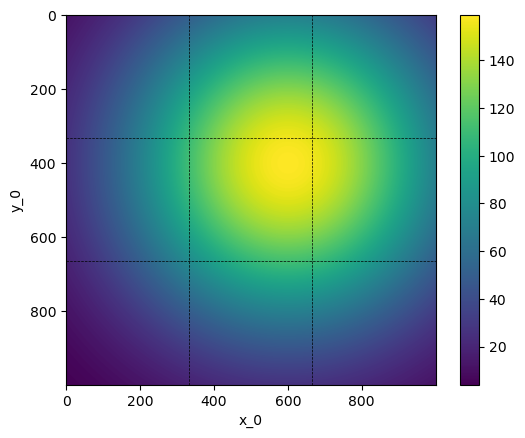

In [15]:
# mean is in center quadrant 
variance = 10*pixel_width

covariance_matrix = np.array([[variance, 0], [0, variance]])

mean_x = (1 + 0.8)*(num_pixels/3)*pixel_width
mean_y = (1 + 0.2)*(num_pixels/3)*pixel_width

mean = np.array([mean_x, mean_y])

base_frame = create_photon_hit_with_gaussian_distribution(mean, variance, data_points)

pixels_per_superpixel = int(num_pixels/3)

plt.imshow(base_frame) 

plt.colorbar()

plt.axvline(x=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=2*pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=2*pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)

plt.xlabel('x_0')
plt.ylabel('y_0')

In [ ]:
### calculate eta distribution

num_frames = 5000

random_number_generator = np.random.default_rng(42)
eta_distribution = calculate_eta_distribution(num_frames, pixels_per_superpixel, random_number_generator, bh.axis.Regular(100, -0.1, 1.0), bh.axis.Regular(100, -0.1, 1.0), False)

filename = os.getenv("AARE_TEST_DATA") + "/eta_distributions/eta_distribution_3x3cluster_gaussian.pkl"
with open(filename, "wb") as f:
    pickle.dump(eta_distribution, f)


In [ ]:
filename = os.getenv("AARE_TEST_DATA") + "/eta_distributions/eta_distribution_3x3cluster_gaussian.pkl"
with open(filename, "rb") as f:
        eta_distribution = pickle.load(f)

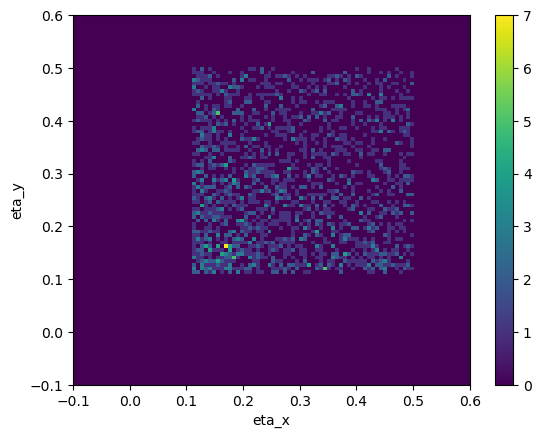

In [7]:
plot_eta_distribution(eta_distribution)

In [14]:
#interpolator = Interpolator(eta_distribution, eta_distribution.axes[0].edges, eta_distribution.axes[1].edges, eta_distribution.axes[2].edges[:-1])

interpolator = Interpolator(eta_distribution.axes[0].edges, eta_distribution.axes[1].edges, eta_distribution.axes[2].edges[:-1])
interpolator.rosenblatttransform(eta_distribution.values())
marg_CDF_etax = interpolator.get_ietax()
cond_CDF_etay = interpolator.get_ietay()


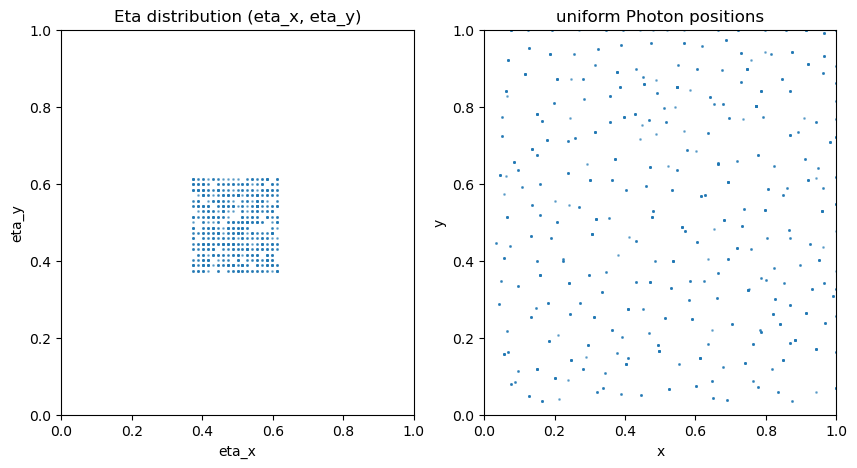

In [15]:

plot_photon_hit_distribution(eta_distribution, marg_CDF_etax, cond_CDF_etay)

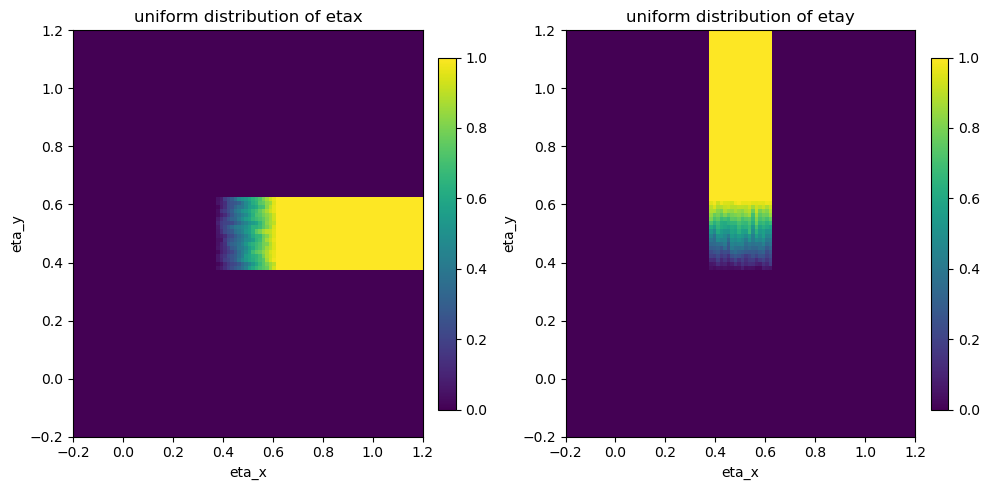

In [ ]:


plot_uniform_eta_distribution(uniform_etax, uniform_etay, [eta_distribution.axes[0].edges[0], eta_distribution.axes[0].edges[-1]])

In [16]:

cluster = create_3x3cluster_from_frame(base_frame, pixels_per_superpixel)

eta = calculate_eta2(cluster)
print(eta)
print(eta_distribution.axes[0].edges)
clustervec = ClusterVector_Cluster3x3d()
#print(marg_CDF_etax)
print(marg_CDF_etax[93, 0,0])
clustervec.push_back(cluster)



photon_hit = interpolator.interpolate(clustervec)

(0.5499154381017892, 0.44933336606613455, 48591988.0)
[-0.1   -0.093 -0.086 -0.079 -0.072 -0.065 -0.058 -0.051 -0.044 -0.037
 -0.03  -0.023 -0.016 -0.009 -0.002  0.005  0.012  0.019  0.026  0.033
  0.04   0.047  0.054  0.061  0.068  0.075  0.082  0.089  0.096  0.103
  0.11   0.117  0.124  0.131  0.138  0.145  0.152  0.159  0.166  0.173
  0.18   0.187  0.194  0.201  0.208  0.215  0.222  0.229  0.236  0.243
  0.25   0.257  0.264  0.271  0.278  0.285  0.292  0.299  0.306  0.313
  0.32   0.327  0.334  0.341  0.348  0.355  0.362  0.369  0.376  0.383
  0.39   0.397  0.404  0.411  0.418  0.425  0.432  0.439  0.446  0.453
  0.46   0.467  0.474  0.481  0.488  0.495  0.502  0.509  0.516  0.523
  0.53   0.537  0.544  0.551  0.558  0.565  0.572  0.579  0.586  0.593
  0.6  ]
0.9999999999999998
dX: 1
dY: 0
u: 1
v: 0


In [17]:
## scale to cluster pixel width 
#cluster_center = (1+0.5)*pixels_per_superpixel*pixel_width

cluster_center = (pixels_per_superpixel*pixel_width*(cluster.x + 0.5), pixels_per_superpixel*pixel_width*(cluster.y + 0.5))

print(photon_hit[0])

scaled_photon_hit = (photon_hit[0][0]*pixels_per_superpixel*pixel_width, photon_hit[0][1]*pixels_per_superpixel*pixel_width)

print(f"previous center: ({cluster_center[0]}, {cluster_center[1]})")
print(f"interpolated center: ({photon_hit[0][0]},{photon_hit[0][1]})")
print(f"scaled interpolated center: ({scaled_photon_hit[0]},{scaled_photon_hit[1]})")
print(f"actual center: ({mean},{mean})")

(1.5000000000000002, 1.5, 48591988.0)
previous center: (0.04995000000000001, 0.04995000000000001)
interpolated center: (1.5000000000000002,1.5)
scaled interpolated center: (0.04995000000000001,0.04995)
actual center: ([0.06 0.04],[0.06 0.04])


Text(0, 0.5, 'y_0')

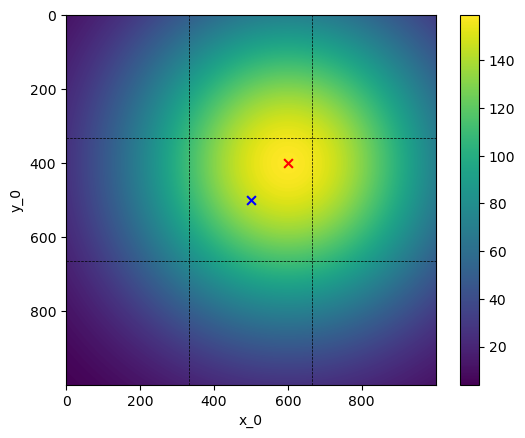

In [18]:
plt.imshow(base_frame) 

plt.colorbar()

plt.axvline(x=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=2*pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=2*pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)

plt.scatter(mean_x/pixel_width, mean_y/pixel_width, color='red', s=40, marker='x', label='Actual photon hit')
plt.scatter(scaled_photon_hit[0]/pixel_width, scaled_photon_hit[1]/pixel_width, color = 'blue', s=40, marker='x', label='interpolated photon hit')

plt.xlabel('x_0')
plt.ylabel('y_0')

## Interpolation with Eta3

In [6]:
from aare._aare import Cluster3x3d, ClusterVector_Cluster3x3d, calculate_eta3, calculate_cross_eta3

Text(0, 0.5, 'y_0')

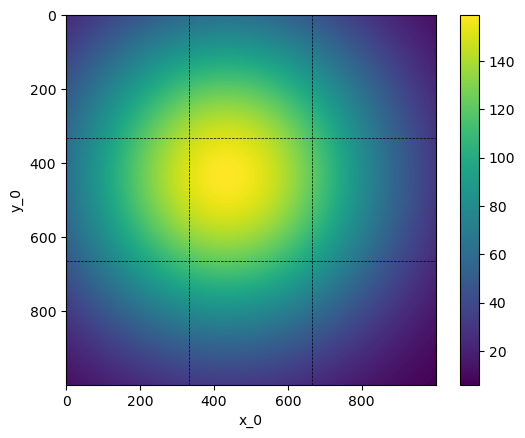

In [4]:
# mean is in center quadrant 
variance = 10*pixel_width

covariance_matrix = np.array([[variance, 0], [0, variance]])

mean = (1 + 0.3)*(num_pixels/3)*pixel_width

mean = np.array([mean, mean])

base_frame = create_photon_hit_with_gaussian_distribution(mean, variance, data_points)

pixels_per_superpixel = int(num_pixels/3)

plt.imshow(base_frame) 

plt.colorbar()

plt.axvline(x=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=2*pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=2*pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)

plt.xlabel('x_0')
plt.ylabel('y_0')

In [7]:
num_frames = 2000

random_number_generator = np.random.default_rng(42)
eta_distribution = calculate_eta_distribution(num_frames, pixels_per_superpixel, random_number_generator, calculate_eta3, False)


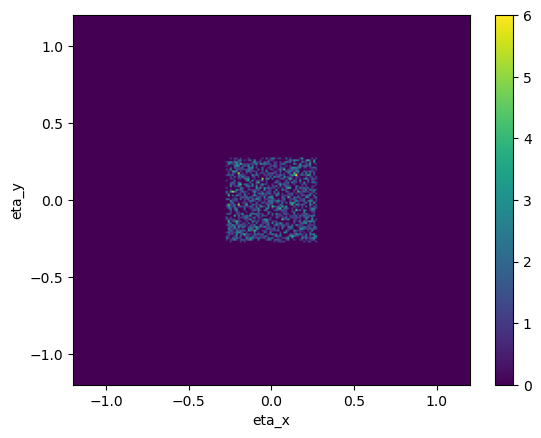

In [8]:
plot_eta_distribution(eta_distribution)

In [9]:
num_frames = 2000

random_number_generator = np.random.default_rng(42)
eta_distribution = calculate_eta_distribution(num_frames, pixels_per_superpixel, random_number_generator, calculate_cross_eta3, False)


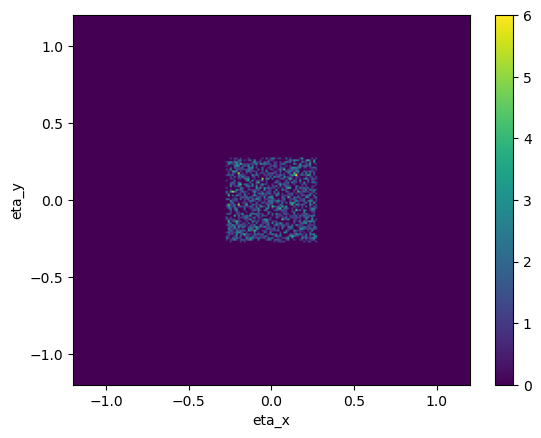

In [10]:
plot_eta_distribution(eta_distribution)